In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from tkinter import *
import os
import sys
from flask import Flask, render_template, request, url_for

In [2]:
# List of dataset filenames or paths
dataset_files = [
    ("./datasets/AAPL.csv","Apple"),
    ("./datasets/GOOGL.csv","Google"),
    ("./datasets/FORD.csv","Ford"),
    ("./datasets/PFZ.csv","Pfizer"),
    ("./datasets/TSLA.csv","Tesla")
]

Graphical comparison of the stock data

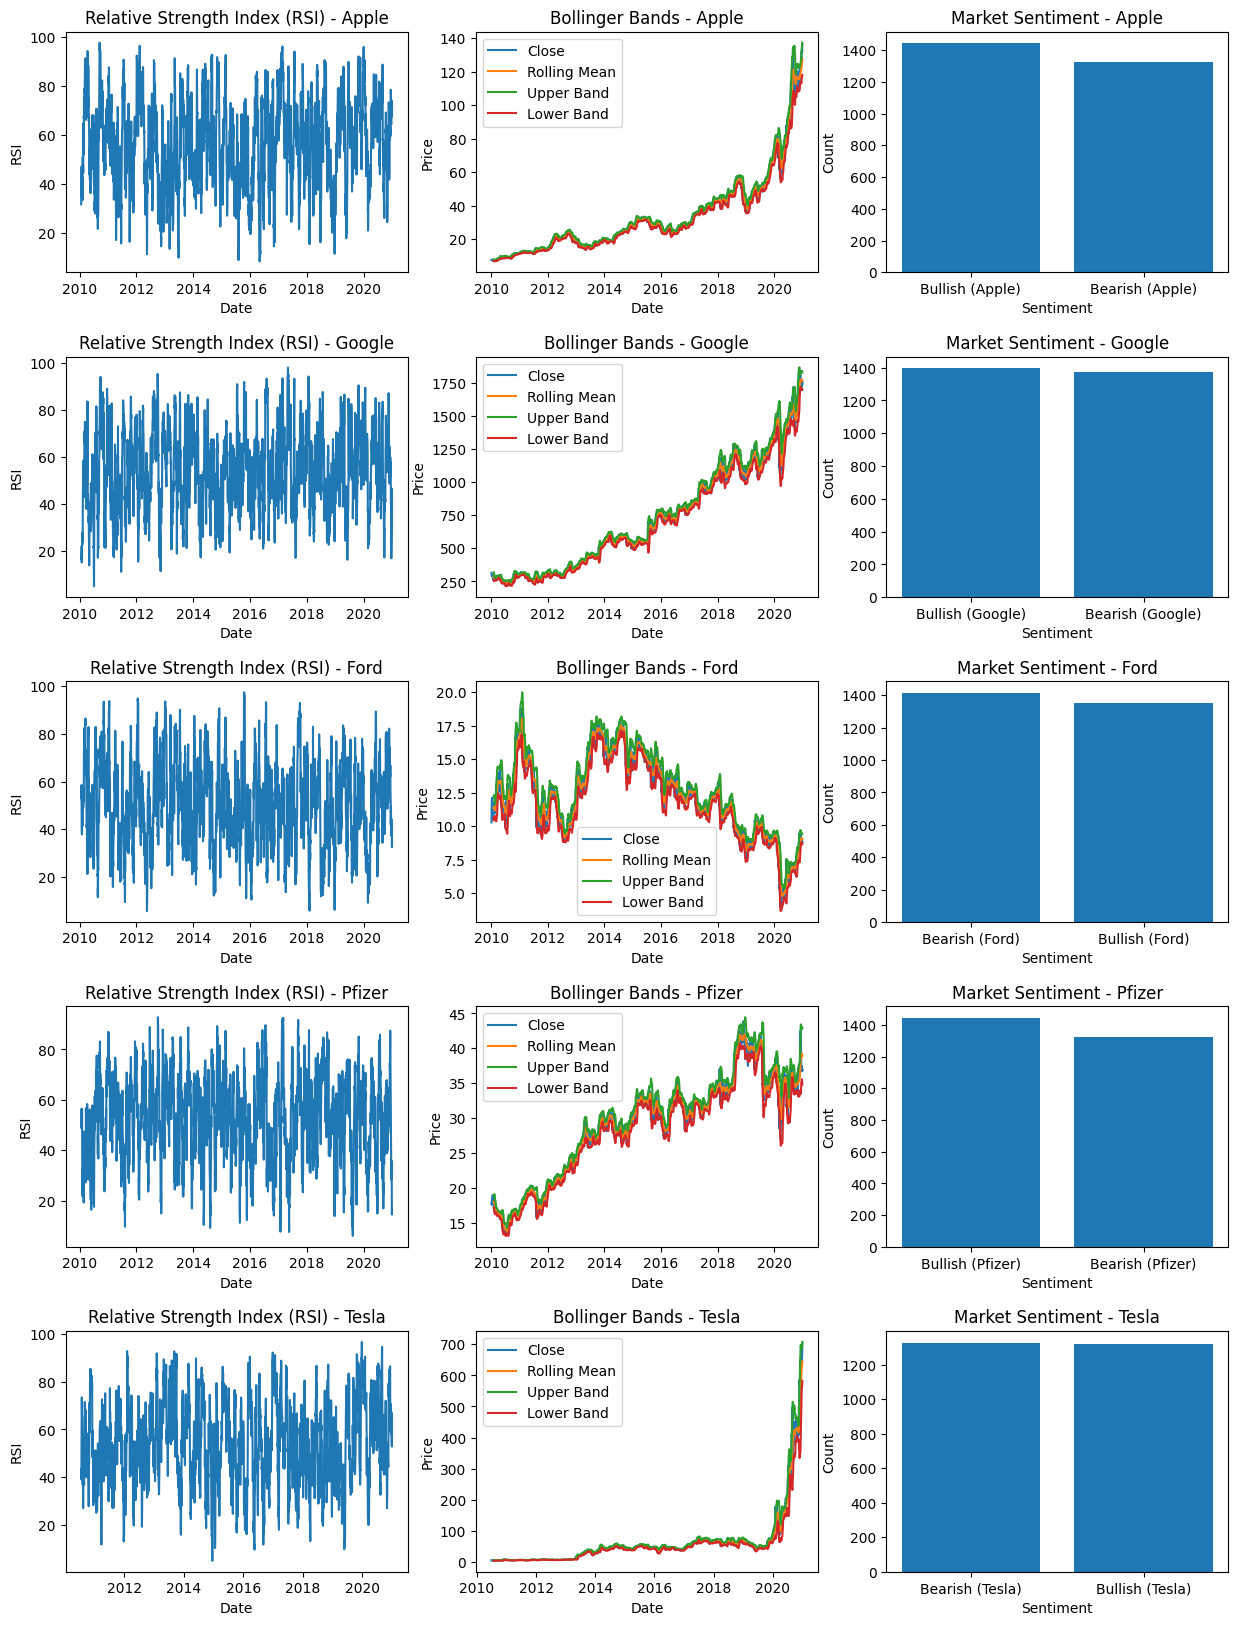

In [3]:
def compare_graphs():
    # Create subplots
    fig, axs = plt.subplots(len(dataset_files), 3, figsize=(15, 4 * len(dataset_files)))

    # Iterate over the datasets
    for i, (file, company) in enumerate(dataset_files):
        # Read the dataset into a DataFrame
        df = pd.read_csv(file)

        # Filter data for the years 2010-2020
        df['Date'] = pd.to_datetime(df['Date'])
        start_date = pd.to_datetime('2010-01-01')
        end_date = pd.to_datetime('2020-12-31')
        df = df.loc[(df['Date'] >= start_date) & (df['Date'] <= end_date)]
    
        # Convert the 'Date' column to datetime format
        df['Date'] = pd.to_datetime(df['Date'])
    
        # Set the 'Date' column as the index
        df.set_index('Date', inplace=True)
    
        # Calculate Relative Strength Index (RSI)
        def calculate_rsi(data, period=14):
            delta = data['Close'].diff()
            gain = delta.where(delta > 0, 0)
            loss = -delta.where(delta < 0, 0)
            avg_gain = gain.rolling(window=period).mean()
            avg_loss = loss.rolling(window=period).mean()
            rs = avg_gain / avg_loss
            rsi = 100 - (100 / (1 + rs))
            return rsi
    
        # Calculate RSI for the dataset
        df['RSI'] = calculate_rsi(df)

        # Plotting RSI
        axs[i, 0].plot(df.index, df['RSI'])
    
        # Calculate Bollinger Bands
        def calculate_bollinger_bands(data, window=20):
            rolling_mean = data['Close'].rolling(window=window).mean()
            rolling_std = data['Close'].rolling(window=window).std()
            upper_band = rolling_mean + 2 * rolling_std
            lower_band = rolling_mean - 2 * rolling_std
            return rolling_mean, upper_band, lower_band
    
        df['Rolling Mean'], df['Upper Band'], df['Lower Band'] = calculate_bollinger_bands(df)
        
        # Plotting Bollinger Bands
        axs[i, 1].plot(df.index, df['Close'], label='Close')
        axs[i, 1].plot(df.index, df['Rolling Mean'], label='Rolling Mean')
        axs[i, 1].plot(df.index, df['Upper Band'], label='Upper Band')
        axs[i, 1].plot(df.index, df['Lower Band'], label='Lower Band')

        # Calculate daily price change percentage
        df['Price Change %'] = (df['Close'] - df['Open']) / df['Open'] * 100
        
        # Classify market sentiment based on price change percentage
        df['Sentiment'] = np.where(df['Price Change %'] >= 0, 'Bullish', 'Bearish')
        
        # Count the number of bullish and bearish days
        sentiment_counts = df['Sentiment'].value_counts()
        
        # Plotting market sentiment
        axs[i, 2].bar(sentiment_counts.index + f' ({company})', sentiment_counts.values)

    # Set axis labels and titles
    for i in range(len(dataset_files)):
        axs[i, 0].set_xlabel('Date')
        axs[i, 0].set_ylabel('RSI')
        axs[i, 0].set_title(f'Relative Strength Index (RSI) - {dataset_files[i][1]}')

    for i in range(len(dataset_files)):
        axs[i, 1].set_xlabel('Date')
        axs[i, 1].set_ylabel('Price')
        axs[i, 1].set_title(f'Bollinger Bands - {dataset_files[i][1]}')
        axs[i, 1].legend()

    for i in range(len(dataset_files)):
        axs[i, 2].set_xlabel('Sentiment')
        axs[i, 2].set_ylabel('Count')
        axs[i, 2].set_title(f'Market Sentiment - {dataset_files[i][1]}')

    plt.subplots_adjust(hspace=0.35)

    # Save the graph as an image file at the specified location
    plt.savefig(r'C:/Users/KIIT/OneDrive/Desktop/Internships/CodeClause/Business Advisor ChatBot/static/compare_graphs.png')

    # Show plots
    plt.show()

compare_graphs()

comparison of all parameters


In [4]:
def compare_companies():
    results = pd.DataFrame(columns=['Company', 'Daily Returns', '50-day MA', 'Cumulative Returns', 'RSI', 'Trading Signal', 'Upper Band', 'Lower Band', 'Price Change %'])

    # Iterate over the datasets
    for file, company in dataset_files:
        # Read the dataset into a DataFrame
        df = pd.read_csv(file)

        # Convert the 'Date' column to datetime format
        df['Date'] = pd.to_datetime(df['Date'])

        # Filter data for the years 2010-2020
        start_date = pd.to_datetime('2010-01-01')
        end_date = pd.to_datetime('2020-12-31')

        df = df.loc[(df['Date'] >= start_date) & (df['Date'] <= end_date)]
        df.set_index('Date', inplace=True)

        #calculate daily returns
        daily_returns = df['Close'].pct_change()

        #calculate 50 day moving avergae
        ma_50 = df['Close'].rolling(window=50).mean()

        #calculate cumulative returns
        cumulative_returns = (1 + daily_returns).cumprod() - 1

        #calculate rsi
        def calculate_rsi(data, period=14):
            delta = data['Close'].diff()
            gain = delta.where(delta > 0, 0)
            loss = -delta.where(delta < 0, 0)
            avg_gain = gain.rolling(window=period).mean()
            avg_loss = loss.rolling(window=period).mean()
            rs = avg_gain / avg_loss
            rsi = 100 - (100 / (1 + rs))
            return rsi
        
        df['RSI'] = calculate_rsi(df)
        df['Signal'] = np.where(df['Close'] > ma_50, 1, -1)

        #calculate bollinger bands
        def calculate_bollinger_bands(data, window=20):
            rolling_mean = data['Close'].rolling(window=window).mean()
            rolling_std = data['Close'].rolling(window=window).std()
            upper_band = rolling_mean + 2 * rolling_std
            lower_band = rolling_mean - 2 * rolling_std
            return upper_band, lower_band
        
        df['Upper Band'], df['Lower Band'] = calculate_bollinger_bands(df)
        df['Price Change %'] = (df['Close'] - df['Open']) / df['Open'] * 100
        
        new_row = pd.DataFrame({
            'Company': [company],
            'Daily Returns': [daily_returns.mean()],
            '50-day MA': [ma_50.mean()],
            'Cumulative Returns': [cumulative_returns.iloc[-1]],
            'RSI': [df['RSI'].mean()],
            'Trading Signal': [df['Signal'].iloc[-1]],
            'Upper Band': [df['Upper Band'].iloc[-1]],
            'Lower Band': [df['Lower Band'].iloc[-1]],
            'Price Change %': [df['Price Change %'].mean()]
        })
        results = pd.concat([results, new_row], ignore_index=True)
    display(results)

compare_companies()

,Company,Daily Returns,50-day MA,Cumulative Returns,RSI,Trading Signal,Upper Band,Lower Band,Price Change %
0,Apple,0.001191,33.198079,16.360498,56.564634,1,137.343586,118.115414,0.020798
1,Google,0.000755,722.411582,4.587195,54.387605,1,1829.076453,1697.854541,-0.004921
2,Ford,0.000140,12.259052,-0.144942,50.137563,1,9.412822,8.654178,-0.092368
3,Pfizer,0.000344,28.946059,1.049537,52.596280,-1,42.833158,34.832842,0.008236
4,Tesla,0.002515,56.369919,146.691499,53.996538,1,707.521025,582.521980,0.041874


future predictions

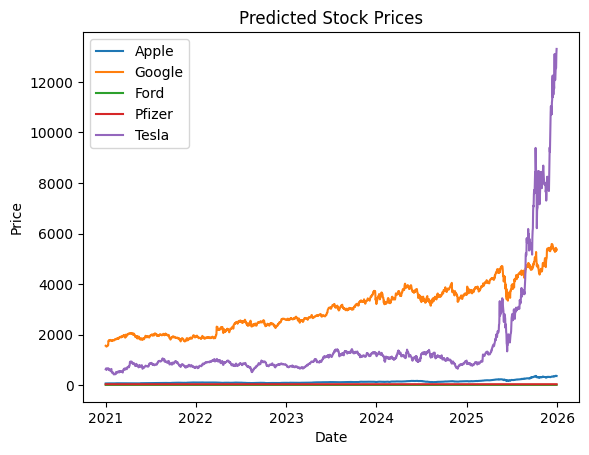

Apple Predictions:


Prediction    134.991784
dtype: float64

Google Predictions:


Prediction    3012.770085
dtype: float64

Ford Predictions:


Prediction    9.443607
dtype: float64

Pfizer Predictions:


Prediction    36.3809
dtype: float64

Tesla Predictions:


Prediction    1568.379408
dtype: float64

In [5]:
def predict_future_prices(days=1825):
    # Create an empty dictionary to store the predictions for each company
    all_predictions = {}
    
    # Iterate over the datasets
    for file, company in dataset_files:
        # Read the dataset into a DataFrame
        df = pd.read_csv(file)

        # Filter data for the years 2010-2020
        df['Date'] = pd.to_datetime(df['Date'])
        start_date = pd.to_datetime('2010-01-01')
        end_date = pd.to_datetime('2020-12-31')
        df = df.loc[(df['Date'] >= start_date) & (df['Date'] <= end_date)]
        
        # Convert the 'Date' column to datetime format
        df['Date'] = pd.to_datetime(df['Date'])
        
        # Set the 'Date' column as the index
        df.set_index('Date', inplace=True)
        
        # Create a new DataFrame with only the 'Close' column
        data = df[['Close']].copy()
        
        # Create a new column 'Prediction' that is shifted 'days' units up
        data['Prediction'] = data[['Close']].shift(-days)
        
        # Create the independent data set (X)
        X = np.array(data.drop(['Prediction'], axis=1))
        
        # Remove the last 'days' rows
        X = X[:-days]
        
        # Create the dependent data set (y)
        y = np.array(data['Prediction'])
        
        # Get all of the y values except the last 'days' rows
        y = y[:-days]
        
        # Split the data into training and testing sets
        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        
        # Create and train the Linear Regression model
        lr = LinearRegression()
        lr.fit(x_train, y_train)
        
        # Get the last 'days' rows of the feature data set
        x_future = data.drop(['Prediction'], axis=1)
        x_future = x_future.tail(days)
        x_future = np.array(x_future)
        
        # Use the model to make predictions
        lr_prediction = lr.predict(x_future)
        
        # Create a new DataFrame with the predicted values
        predictions = pd.DataFrame(lr_prediction, index=pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=days, freq='D'), columns=['Prediction'])
        
        # Add the predictions to the dictionary of all predictions
        all_predictions[company] = predictions
    
    # Plot the predicted stock prices for each company
    for company, predictions in all_predictions.items():
        plt.plot(predictions.index, predictions.values, label=company)
    
    plt.title('Predicted Stock Prices')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    # Save the graph as an image file at the specified location
    plt.savefig(r'C:/Users/KIIT/OneDrive/Desktop/Internships/CodeClause/Business Advisor ChatBot/static/future_predictions.png')
    plt.show()
    
    return all_predictions
# Call the predict_future_prices function to generate and plot the predictions
all_predictions = predict_future_prices(1825)

# Display the DataFrames with the predicted stock prices for each company
for company, predictions in all_predictions.items():
    print(f"{company} Predictions:")
    display(predictions.mean())


Main Chatbot Loop

In [6]:
from flask import Flask, render_template, request
app = Flask(__name__, template_folder='./templates')

@app.route('/')
def index():
    return render_template('index.html')

@app.route('/send_message', methods=['POST'])
def send_message():
    message = request.form['message']
    # Process the user's message and generate a response
    response = process_message(message)
    return response

def process_message(message):
    # Implement your chatbot logic here
    if message.lower() in ["hello", "hey", "hi"]:
        return "Hi there, how can I help?"
    elif message.lower() in ["what can you do", "what do you do"]:
        return "I'm a Business Advisor Chatbot. I've analysed the historical stock data of 5 different companies- Apple, Google, Ford, Pfizer and Tesla. I can do 3 things- Give you my historical stock data analysis, show you their graphical representation, or give you future stock price predictions, along with a graphical comparison. Type 1, 2, or 3 respectively to continue."
    elif message == '1':
        return "What do you want to know about?\na:Daily returns\nb:50-day moving avergaes\nc:Cumulative returns\nd:RSI\ne:Trading signal\nf:Bollinger bands\ng:Price Change percentage"
    elif message == 'a':
        return "The Daily returns are-\nApple = 0.001191\nGoogle = 0.000755\nFord = 0.000140\nPfizer = 0.000344\nTesla = 0.002515\nThus we can see that all companies have had positive daily averages"
    elif message == 'b':
        return "The 50 day moving averages are-\nApple = 33.198079\nGoogle = 722.411582\nFord = 12.259052\nPfizer = 28.946059\nTesla = 56.369919\nHere, we can see that all the companies were trading above their 50 day moving averages, thus indicating an upward trend"
    elif message == 'c':
        return "The Cumulative returns are-\nApple = 16.360498\nGoogle = 4.587195\nFord = -0.144942\nPfizer = 1.049537\nTesla = 146.691499\nApple, Google, and Tesla have the highest cumulative returns, while Ford has a negative cumulative return."
    elif message == 'd':
        return "The RSI for the comapnies is-\nApple = 56.564634\nGoogle = 54.387605\nFord = 50.137563\nPfizer = 52.596280\nTesla = 53.996538\nThe RSI values for all companies are above 50, indicating that they may be overbought."
    elif message == 'e':
        return "The Trading signals are-\nApple = 1\nGoogle = 1\nFord = 1\nPfizer = -1\nTesla = 1\nThe trading signals suggest buying Apple, Google, Ford, and Tesla, and selling Pfizer."
    elif message == 'f':
        return "The Bollinger bands are-\nApple: UB=137.343586 LB=118.115414\nGoogle : UB=1829.076453 LB=1697.854541\nFord : UB=9.412822 LB=8.654178\nPfizer : UB=42.833158 LB=34.832842\nTesla : UB=707.521025 LB=582.521980\nAll companies are trading within their Bollinger Bands, with no clear indication of being overbought or oversold."
    elif message == 'g':
        return "The price change % is-\nApple = 0.020798\nGoogle = -0.004921\nFord = -0.092368\nPfizer = 0.008236\nTesla = 0.041874\nApple, Pfizer, and Tesla have positive price changes, indicating that their prices have increased over the given period of time. Google and Ford have negative price changes, indicating that their prices have decreased over the given period of time."
    elif message == '2':
        image_url = url_for('static', filename='compare_graphs.png')
        # Return a link to the image
        return '<a href="{}">View Comparison Graph</a>'.format(image_url)
    elif message == '3':
        image_url = url_for('static', filename='future_predictions.png')
        response = "The mean of the predicted close stock prices are:\nApple = 128.339901\nGoogle = 3054.617385\nFord = 9.367138\nPfizer = 36.530835\nTesla = 1543.731475.\n"
        response += '<a href="{}"> Click to view the graph.</a>'.format(image_url)
        return response
    else:
        return "Sorry! I didn't understand that"

if __name__ == '__main__':
    app.run()


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [28/Jul/2023 02:31:56] "GET / HTTP/1.1" 200 -
